# Perform unfolding on EEG data from Stop-signal task

TODO

In [94]:
import pickle
import warnings
import os

import mne
import seaborn as sns
import matplotlib.pyplot as plt

import unfold_model

# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

  Activating project at `~/Projects/neuroNoodle/unfold`


Status `~/Projects/neuroNoodle/unfold/Project.toml`
  [a93c6f00] DataFrames v1.7.0
  [181c99d8] Unfold v0.7.6
None
  [ec0f67a1] UnfoldDecode v0.1.0 `https://github.com/unfoldtoolbox/UnfoldDecode.jl#main`


   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/unfold/Project.toml`
  No Changes to `~/Projects/neuroNoodle/unfold/Manifest.toml`
Precompiling project...
  ✓ NNlib → NNlibFFTWExt
  1 dependency successfully precompiled in 6 seconds. 229 already precompiled.
   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/unfold/Project.toml`
  No Changes to `~/Projects/neuroNoodle/unfold/Manifest.toml`
    Updating git-repo `https://github.com/unfoldtoolbox/UnfoldDecode.jl`
   Resolving package versions...
  No Changes to `~/Projects/neuroNoodle/unfold/Project.toml`
  No Changes to `~/Projects/neuroNoodle/unfold/Manifest.toml`


Define output dir and loggers

In [95]:
output_dir = '../data/unfold_output'

Define picks

In [96]:
picks = [
    'Fp1',
    'AF3',
    'F7',
    'F3',
    'FC1',
    'FC5',
    'T7',
    'C3',
    'CP1',
    'CP5',
    'P7',
    'P3',
    'Pz',
    'PO3',
    'O1',
    'Oz',
    'O2',
    'PO4',
    'P4',
    'P8',
    'CP6',
    'CP2',
    'C4',
    'T8',
    'FC6',
    'FC2',
    'F4',
    'F8',
    'AF4',
    'Fp2',
    'Fz',
    'Cz',
]

## Read events and EEG data

In [97]:
events_data_dir = '../data/output'
eeg_data_dir = '../data/Export SST N=54_Correct filtr 0.1-15 Hz'

pickle_events_files = sorted([f for f in os.listdir(events_data_dir) if f.endswith('.pickle')])
file_names = [os.path.splitext(f)[0] for f in pickle_events_files]

## Perform unfolding

In [98]:
for file_name in file_names[:1]:
    try:
        # read events dict
        with open(f'{events_data_dir}/{file_name}.pickle', 'rb') as handle:
            events = pickle.load(handle) # events dict channel_name:events_df

        # read EEG
        raw = mne.io.read_raw_brainvision(
            f'{eeg_data_dir}/{file_name}.vhdr', 
            preload=True, 
            eog=('HEOG', 'VEOG'),
        ).pick(picks=picks)
        
        # perform unfolding separately for each channel
        channels = raw.info['ch_names']
        results_channels = dict()
        for channel in channels:
            channel_events_df = events[channel]
            # clear bad segments
            # TODO
            eeg_data = raw.get_data(picks=channel)
            # cast from V to uV
            eeg_data = eeg_data * 1000000
            
            results_channel = unfold_model.perform_unfold(channel_events_df, eeg_data)
            results_channels[channel] = results_channel

        # save results into pickle
        output_file = f"{output_dir}/{file_name}"
        with open(f'{output_file}.pickle', 'wb') as handle:
            pickle.dump(results_channels, handle, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print(e)

Extracting parameters from ../data/Export SST N=54_Correct filtr 0.1-15 Hz/AB0407_SST14_EOG4.vhdr...
Setting channel info structure...
Reading 0 ... 22769  =      0.000 ...   355.766 secs...


/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_64863/2146334096.py:8: RuntimeWarning: No coordinate information found for channels ['A1', 'A2']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(
/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_64863/2146334096.py:8: RuntimeWarning: Not setting positions of 4 eog/misc channels found in montage:
['HEOG', 'VEOG', 'A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(


## Plot results

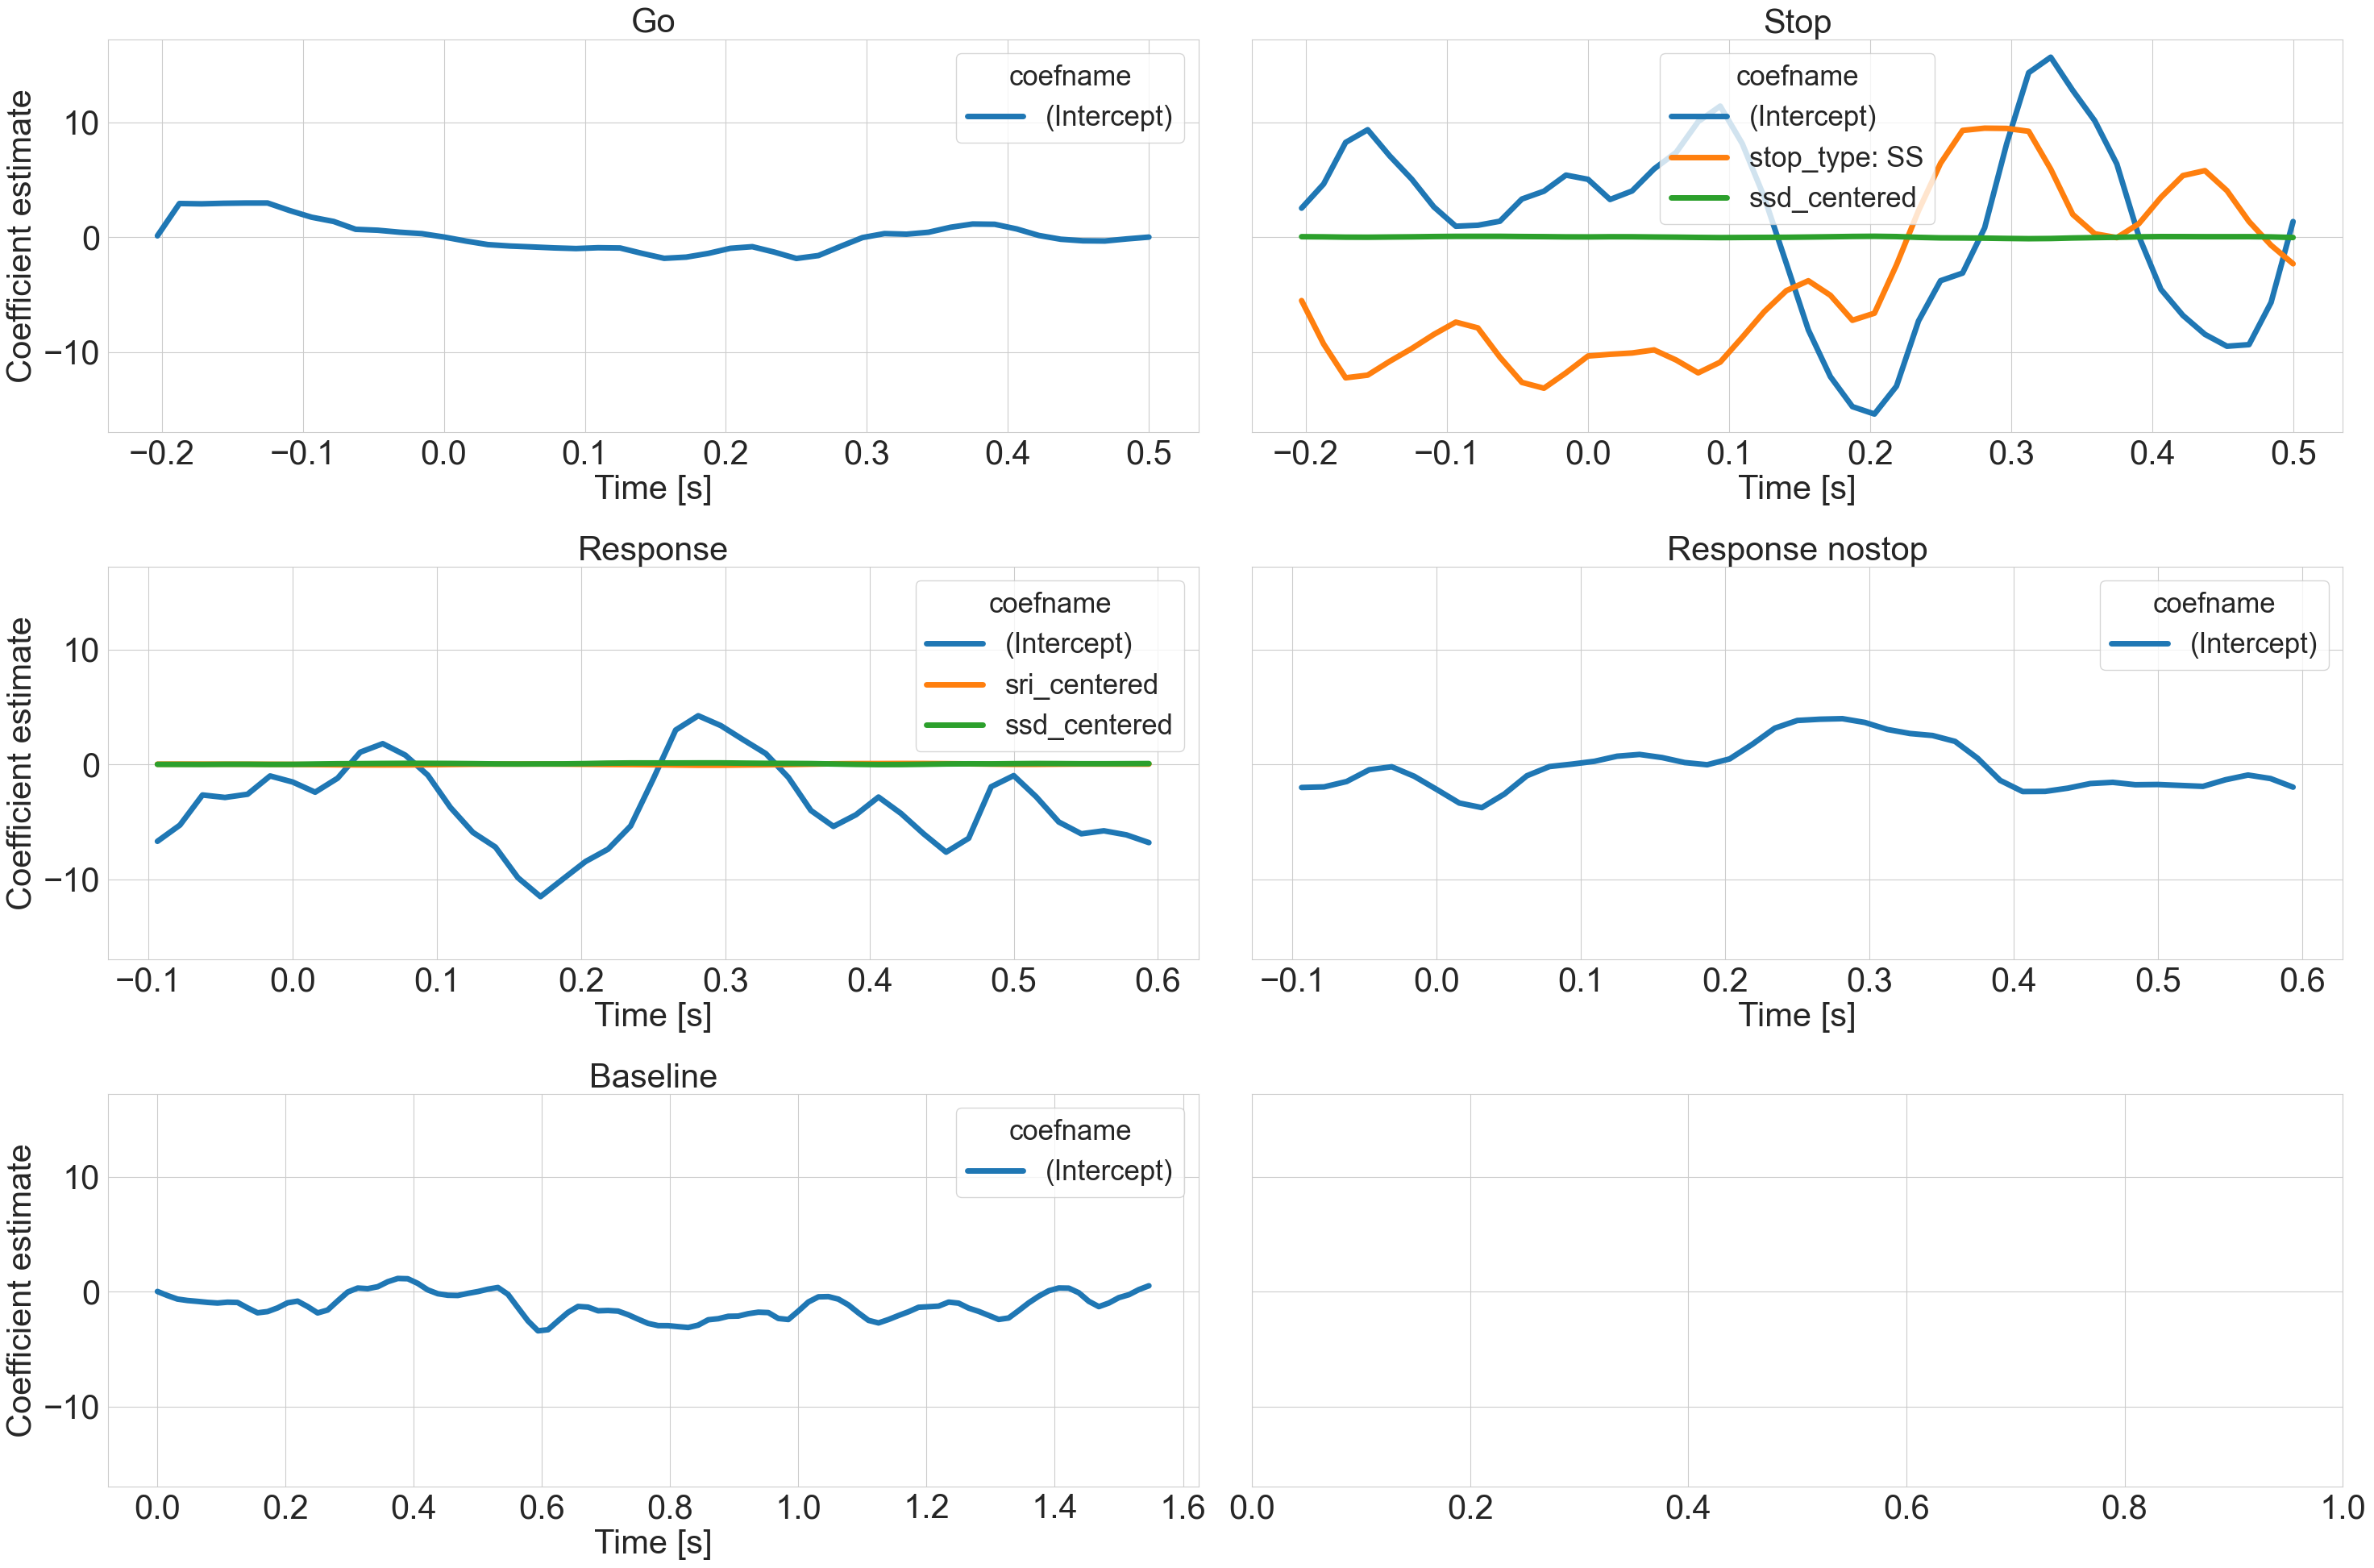

In [99]:
channel_name = 'Fz'
results_channel = results_channels[channel_name]

results_baseline = results_channel[results_channel.eventname == 'baseline']
results_go = results_channel[results_channel.eventname == 'go']
results_stop = results_channel[results_channel.eventname == 'stop']
results_response = results_channel[results_channel.eventname == 'response_stop']
results_response_nostop = results_channel[results_channel.eventname == 'response_nostop']

sns.set_style("whitegrid")

# Set global font size for various elements
plt.rcParams.update({
    'font.size': 25,
    'axes.titlesize': 30,
    'axes.labelsize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 25,
    'figure.titlesize': 25,
})
linewidth = 5
# Plot the coefficient estimates over time
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(30, 20), sharey=True)

ax1 = sns.lineplot(
    x = results_go.time,
    y=results_go.estimate,
    hue=results_go.coefname,
    ax=ax1,
    linewidth=linewidth
)
ax1.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Go')

ax2 = sns.lineplot(
    x = results_stop.time,
    y=results_stop.estimate,
    hue=results_stop.coefname,
    ax=ax2,
    linewidth=linewidth
)
ax2.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Stop')

ax3 = sns.lineplot(
    x = results_response.time,
    y=results_response.estimate,
    hue=results_response.coefname,
    ax=ax3,
    linewidth=linewidth
)
ax3.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Response')

ax4 = sns.lineplot(
    x = results_response_nostop.time,
    y=results_response_nostop.estimate,
    hue=results_response_nostop.coefname,
    ax=ax4,
    linewidth=linewidth
)
ax4.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Response nostop')

ax5 = sns.lineplot(
    x = results_baseline.time,
    y=results_baseline.estimate,
    hue=results_baseline.coefname,
    ax=ax5,
    linewidth=linewidth
)
ax5.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Baseline')

plt.tight_layout()